# Largest Change in Temperature

In [44]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import seaborn as sns
import os, warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [173]:
cityTemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalLandTemperaturesByCity.csv')
ctrTemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalLandTemperaturesByCountry.csv')
globtemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalTemperatures.csv')

In [174]:
globtemp['dt'] = pd.to_datetime(globtemp['dt'])
globtemp['Year'] = globtemp['dt'].apply(lambda x : x.strftime('%Y'))
globTemp = globtemp.groupby('Year').mean().reset_index(drop=False)
globTemp = globTemp[['Year']+['LandAverageTemperature']+['LandAverageTemperatureUncertainty']]
globAvg = globTemp['LandAverageTemperature'].mean()
globTemp['LandAverageTemperature'] = globTemp['LandAverageTemperature'].apply(lambda x : x - globAvg)
globTemp['Upper'] = globTemp['LandAverageTemperature'] + globTemp['LandAverageTemperatureUncertainty']
globTemp['Lower'] = globTemp['LandAverageTemperature'] - globTemp['LandAverageTemperatureUncertainty']
# globTemp.head()

In [137]:
countryTemp = ctrTemp.dropna()
#List of continents
continents = ['North America','South America','Europe','Asia','Africa','Australia','Antarcita']
#Remove continents from country temp
countryTemp = ctrTemp[~ctrTemp['Country'].isin(continents)]
countryTemp = countryTemp[~countryTemp['Country'].str.contains('(Europe)')]
countryTemp = countryTemp.dropna()
countryTemp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
5,1744-04-01,1.530,4.680,Åland
6,1744-05-01,6.702,1.789,Åland
7,1744-06-01,11.609,1.577,Åland
8,1744-07-01,15.342,1.410,Åland


In [138]:
countryTemp['dt'] = pd.to_datetime(countryTemp['dt'])
countryTemp['Year'] = countryTemp['dt'].apply(lambda x : x.strftime('%Y'))
countryTemp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Year
0,1743-11-01,4.384,2.294,Åland,1743
5,1744-04-01,1.530,4.680,Åland,1744
6,1744-05-01,6.702,1.789,Åland,1744
7,1744-06-01,11.609,1.577,Åland,1744
8,1744-07-01,15.342,1.410,Åland,1744


In [139]:
yearTemp = countryTemp.groupby(['Country','Year']).mean().reset_index(drop=False)
yearTemp['Uncertainty'] = yearTemp['AverageTemperatureUncertainty']/yearTemp['AverageTemperature']
yearTemp.head()

,Country,Year,AverageTemperature,AverageTemperatureUncertainty,Uncertainty
0,Afghanistan,1838,18.379571,2.756000,0.149949
1,Afghanistan,1840,13.413455,2.502000,0.186529
2,Afghanistan,1841,13.997600,2.452100,0.175180
3,Afghanistan,1842,15.154667,2.381222,0.157128
4,Afghanistan,1843,13.756250,2.353083,0.171056


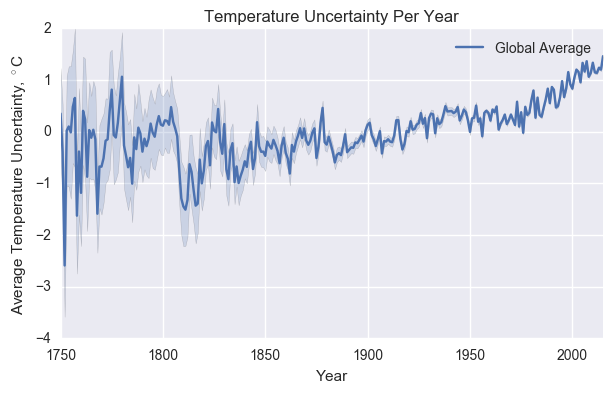

In [177]:
plt.figure(figsize=(7,4))
data = [globTemp['LandAverageTemperature'].values,globTemp['Upper'].values,globTemp['Lower'].values]
ax = sns.tsplot(time=globTemp['Year'], value="Temperature, $^\circ$C", 
                condition="Global Average",data=data) 
ax.set_ylabel('Average Temperature Uncertainty, $^\circ$C')
ax.set_title('Temperature Uncertainty Per Year')
plt.savefig("./ana_2/globalAverage.pdf", bbox_inches='tight')

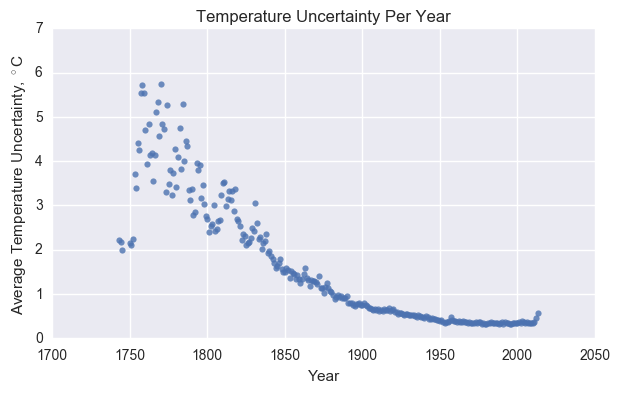

In [120]:
avgUnc = yearTemp.groupby('Year').mean().reset_index(drop=False)
data = avgUnc['Year'].apply(lambda x:int(x))
plt.figure(figsize=(7,4))
ax=sns.regplot(data,avgUnc['AverageTemperatureUncertainty'],fit_reg=False) 
ax.set_ylabel('Average Temperature Uncertainty, $^\circ$C')
ax.set_title('Temperature Uncertainty Per Year')
plt.savefig("./ana_2/uncertaintyPlot.pdf", bbox_inches='tight')

In [150]:
test = avgUnc[avgUnc['AverageTemperatureUncertainty'] <= 1.5]
test.head(10)

,Year,AverageTemperature,AverageTemperatureUncertainty,Uncertainty
106,1853,16.485486,1.363386,0.175033
108,1855,16.491861,1.465336,0.146311
109,1856,17.585535,1.459401,0.088001
110,1857,17.352906,1.337065,0.144744
111,1858,17.579217,1.438148,0.106251
112,1859,18.080226,1.329732,0.144271
113,1860,17.498630,1.249689,0.102734
114,1861,17.582417,1.341499,0.125544
115,1862,16.977373,1.455206,0.086323
117,1864,17.018095,1.352433,0.117227


In [151]:
#Seeing as the average uncertainty falls below 1.5 degrees at 1850, I feel that is
#a good year to use as a cutoff year
cutOffYear = '1860'
#Using that generalized year wasn't quite good enough so I also removed data which had
#an uncertainty greater than 1.5 degrees

In [164]:
#Top five temperature deltas since between 1850 and 2013
tempTemp = yearTemp[yearTemp['Year'] > cutOffYear]
tempTemp = tempTemp[tempTemp['AverageTemperatureUncertainty'] < 1.5]
countries = tempTemp['Country'].unique()
listHolder = []
for each in countries:
    holder = tempTemp[tempTemp['Country'] == each]
    holder.sort_values('Year')
    oldTemp = holder['AverageTemperature'].head(5).mean()
    minYear = holder['Year'].iloc[0]
    newTemp = holder['AverageTemperature'].tail(5).mean()
    diffTemp = newTemp - oldTemp
    listHolder.append((each,minYear,oldTemp,newTemp,diffTemp))
    
diffs = DataFrame(listHolder, columns=('Country',
                                       'FirstYear',
                                       'OldTemp',
                                       'NewTemp',
                                       'DiffTemp')).sort_values(by='DiffTemp', ascending=False).reset_index(drop=True)

diffs.head()

,Country,FirstYear,OldTemp,NewTemp,DiffTemp
0,Canada,1882,-6.132433,-2.879517,3.252917
1,Azerbaijan,1861,10.396217,13.128725,2.732508
2,Ukraine,1861,7.021333,9.575300,2.553967
3,Armenia,1861,7.967367,10.436417,2.469050
4,United Arab Emirates,1861,26.951380,29.360175,2.408795


In [154]:
diffs.tail()

,Country,FirstYear,OldTemp,NewTemp,DiffTemp
227,Botswana,1882,21.446300,22.210167,0.763867
228,New Zealand,1855,10.246650,10.979600,0.732950
229,Uruguay,1861,17.057483,17.775875,0.718392
230,Timor Leste,1878,25.782160,26.394750,0.612590
231,Ireland,1843,9.367383,9.954283,0.586900


In [160]:
diffs[diffs['Country']=='Greenland']

,Country,FirstYear,OldTemp,NewTemp,DiffTemp
208,Greenland,1925,-17.458483,-16.443817,1.014667


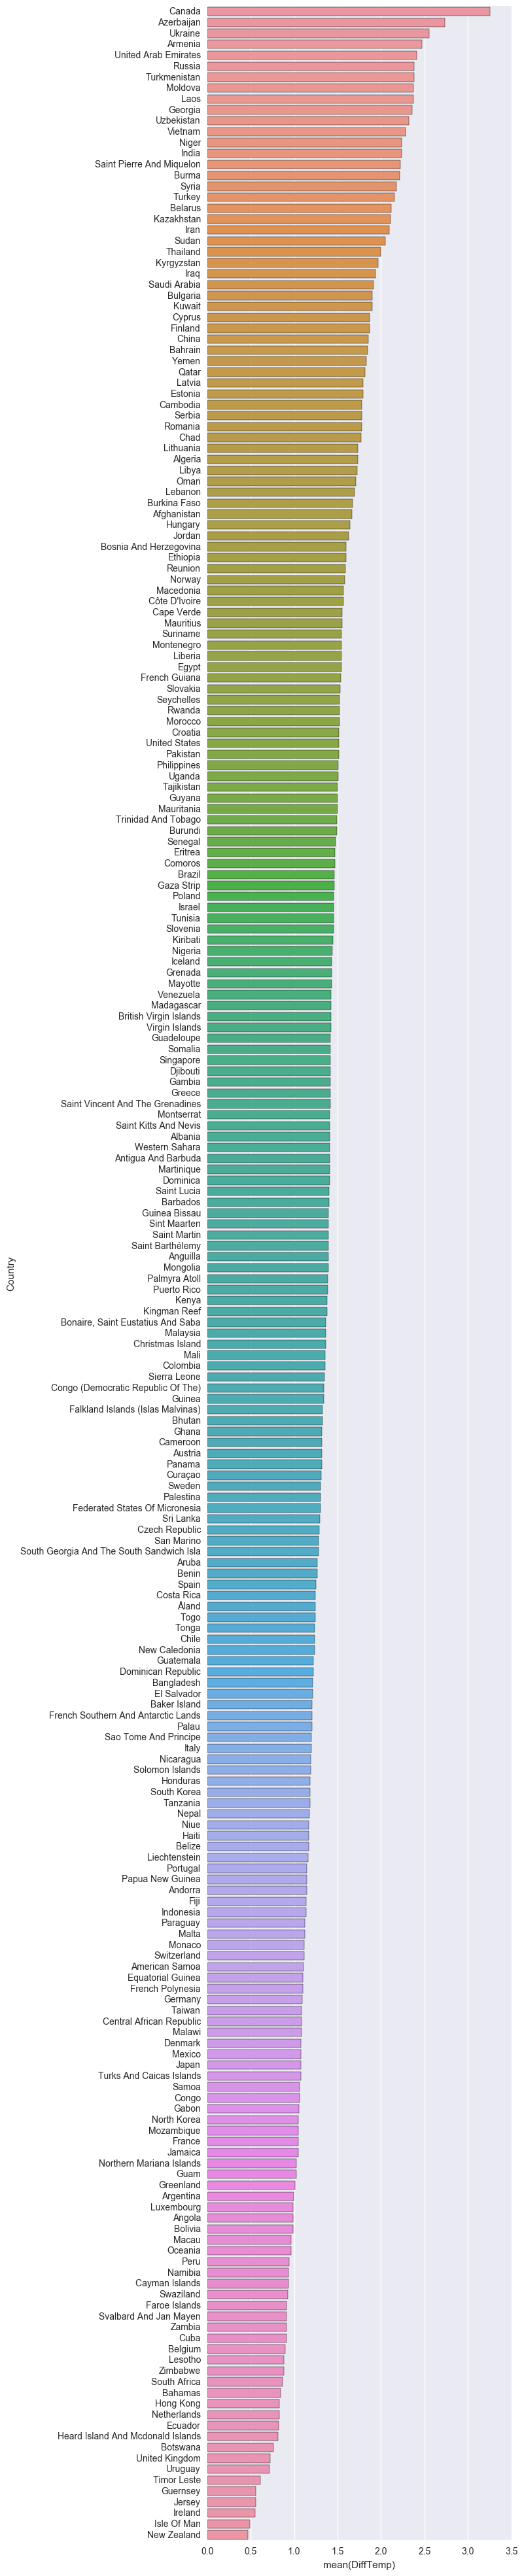

In [165]:
plt.figure(figsize=(6,50))
sns.barplot(diffs['DiffTemp'],diffs['Country'])

In [168]:
print(len(diffs[diffs['DiffTemp'] > 2.25]))

12


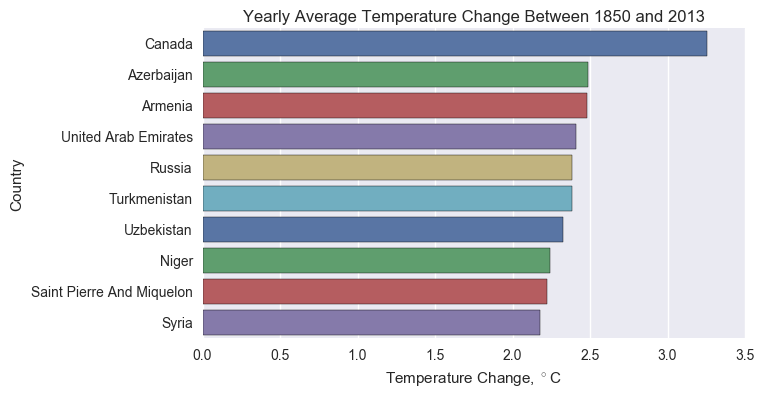

In [161]:
plt.figure(figsize=(7,4))
ax = sns.barplot(diffs['DiffTemp'][0:10],diffs['Country'][0:10],palette='deep')
ax.set_xlabel('Temperature Change, $^\circ$C')
ax.set_title('Yearly Average Temperature Change Between 1850 and 2013')
plt.savefig("./ana_2/topTenDelta.pdf", bbox_inches='tight')

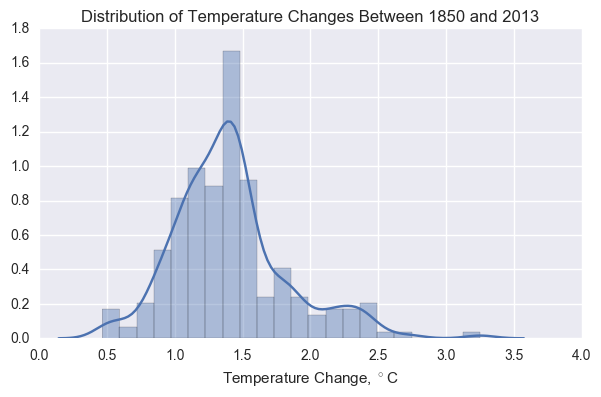

In [171]:
plt.figure(figsize=(7,4))
ax = sns.distplot(diffs['DiffTemp'])
ax.set_title('Distribution of Temperature Changes Between 1850 and 2013')
ax.set_xlabel('Temperature Change, $^\circ$C')
plt.savefig("./ana_2/deltahist.pdf", bbox_inches='tight')

In [51]:
test = mins[mins['Uncertainty'] < 0.1]
print(countryTemp['Country'].nunique())
print(test['Country'].nunique())
print(test['Country'].value_counts())

243
239
Svalbard And Jan Mayen               252
Canada                               215
Bangladesh                           210
Sri Lanka                            208
India                                207
Russia                               202
Bahamas                              201
Algeria                              200
Western Sahara                       192
Turks And Caicas Islands             191
Denmark                              191
Cayman Islands                       191
Greenland                            191
Cuba                                 190
Thailand                             190
Jamaica                              189
Haiti                                189
Dominican Republic                   188
Burma                                188
Laos                                 188
Honduras                             187
Guatemala                            187
Belize                               187
Libya                                184
Nicaragu